In [1]:
from rdkit import Chem
import numpy as np
import pandas as pd
from IPython.display import display
import tqdm

# Load simulator data

In [2]:
dataset = pd.read_csv("/home/abhor/Desktop/datasets/my_uspto/action_dataset.csv", index_col=0)

In [3]:
dataset

,reactants,products,rsig,psig,rcen,pcen,rsig_clusters
0,CON(C)C(=O)c1ccc(O)nc1,CC(C)CC(=O)c1ccc(O)nc1,[CH3:0][O:1][NH:2][CH3:3],[CH3:0][CH:1]([CH3:2])[CH3:3],2,3,0
510,CON(C)C(=O)c1cn(-c2cccc(-c3ccccc3Cl)c2)cn1,O=C(c1cccc(F)c1)c1cn(-c2cccc(-c3ccccc3Cl)c2)cn1,[CH3:0][O:1][NH:2][CH3:3],[cH:0]1[cH:1][cH:2][cH:3][c:4]([F:5])[cH:6]1,2,2,0
32170,CON(C)C(=O)c1cn(-c2cccc(-c3c(F)ccnc3F)c2)cn1,O=C(c1ccc(F)cc1)c1cn(-c2cccc(-c3c(F)ccnc3F)c2)cn1,[CH3:0][O:1][NH:2][CH3:3],[cH:0]1[cH:1][cH:2][c:3]([F:4])[cH:5][cH:6]1,2,2,0
68243,CON(C)C(=O)c1ccc2nc(N)c(-c3ccccc3)n2c1,Nc1nc2ccc(C(=O)c3ccccc3F)cn2c1-c1ccccc1,[CH3:0][O:1][NH:2][CH3:3],[cH:0]1[cH:1][cH:2][cH:3][cH:4][c:5]1[F:6],2,6,0
1485,CON(C)C(=O)Cc1ccc(OC2CCCCC2)cc1,CCCCC(=O)Cc1ccc(OC2CCCCC2)cc1,[CH3:0][O:1][NH:2][CH3:3],[CH3:0][CH2:1][CH2:2][CH3:3],2,3,0
...,...,...,...,...,...,...,...
448180,Cc1ccc(S(=O)(=O)OCCC=C(F)F)cc1,Cc1ccc(S(=O)(=O)[O-])cc1,[CH3:0][CH2:1][CH:2]=[C:3]([F:4])[F:5],[H:0],5,0,401854
448392,CCNC(=O)n1nc(N)c2cc(C(F)(F)F)ccc21,CCN=C=O,[CH:0](=[O:1])[n:2]1[n:3][c:4]([NH2:5])[c:6]2[...,[CH2:0]=[O:1],3,1,401983
448400,CCC(=C(c1ccc(OCCN(C)C)cc1)c1ccc(OP(=O)([O-])[O...,CCC(=C(c1ccc([Na])cc1)c1ccc(OCCN(C)C)cc1)c1ccccc1,[OH:0][P:1](=[O:2])([O-:3])[O-:4],[Na:0],4,0,401990
448436,CC(C)CP(CC(C)C)CC(C)C,CCCCOP(=O)([O-])OCCCC,[CH3:0][P:1]([CH2:2][CH:3]([CH3:4])[CH3:5])[CH...,[CH3:0][O:1][P:2](=[O:3])([O-:4])[O:5][CH2:6][...,3,3,402014


# Indexing and searching

In [4]:
import pynauty
import networkx as nx

In [5]:
# Fetch the rsigs using the clusters
unique_rsig_dict = {}
for cluster_id in dataset["rsig_clusters"].unique():
    cluster_df = dataset[dataset["rsig_clusters"] == cluster_id]
    rsig  = Chem.MolFromSmiles(cluster_df.iloc[0]["rsig"])
    unique_rsig_dict[cluster_id] = rsig
    
print(f"There are {len(unique_rsig_dict)} unique rsigs.")

There are 3967 unique rsigs.


In [10]:
# For each rsig, genearate a certificate
def get_mol_certificate(mol):
    adj_mat = Chem.GetAdjacencyMatrix(mol)

    # Create a ring for each atom with size = atomic_num
    atom_nums = np.array([atom.GetAtomicNum() for atom in list(mol.GetAtoms())])
    atom_nums[atom_nums == 6] = 1
    mat_list = []
    for atn in atom_nums:
        new_mat = np.zeros(shape=(atn, atn), dtype=np.int8)
        for i in range(atn):
            new_mat[i, (i+1)%atn] = 1
        mat_list.append(new_mat)

    # conbine the rings into a new adj mat
    new_adj_mat = np.zeros(shape=(sum(atom_nums), sum(atom_nums)), dtype=np.int8)
    idx = 0
    for i in range(len(atom_nums)):
        new_adj_mat[idx:idx+atom_nums[i], idx:idx+atom_nums[i]] = mat_list[i]
        idx += atom_nums[i]

    # add original last connections
    idx = 0
    for i, a_i in enumerate(np.cumsum(atom_nums)):
        for j, a_j in enumerate(np.cumsum(atom_nums)):
            new_adj_mat[a_i-1, a_j-1] = adj_mat[i, j]

    adj_mat = new_adj_mat
    
    # convert adj matrix to adj dict
    adj_dict = {}
    for i, row in enumerate(adj_mat):
        adj_dict[i] = [x for x, j in enumerate(row) if j]
        
    # get graph
    G = pynauty.Graph(len(adj_dict), directed=False, adjacency_dict=adj_dict)#, vertex_coloring=coloring)
    
    # return certificate
    return pynauty.certificate(G)
        
certificate_to_cluster_id_dict = {}
for _id in tqdm.tqdm(unique_rsig_dict):
    C = get_mol_certificate(unique_rsig_dict[_id])
    if C in certificate_to_cluster_id_dict:
        certificate_to_cluster_id_dict[C].append(_id)
    else:
        certificate_to_cluster_id_dict[C] = [_id]

100%|██████████████████████████████████████████████████████████| 3967/3967 [00:01<00:00, 2836.17it/s]


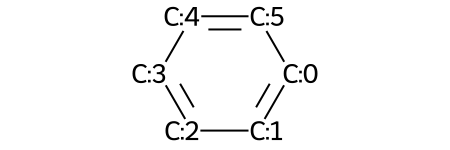

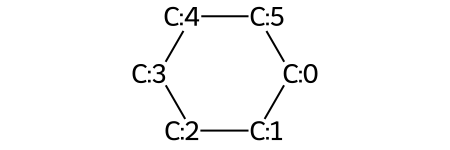

In [7]:
for key in list(certificate_to_cluster_id_dict.keys())[14:]:
    for i in certificate_to_cluster_id_dict[key]:
        display(Chem.MolFromSmiles(dataset[dataset["rsig_clusters"]==i].iloc[0]["rsig"]))
    break

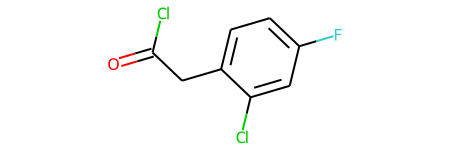

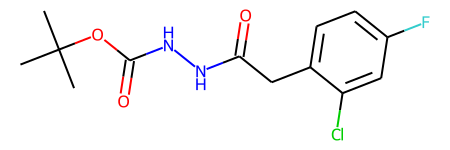

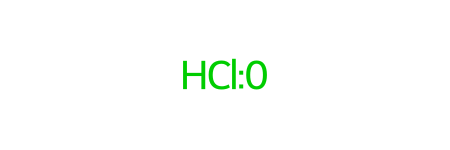

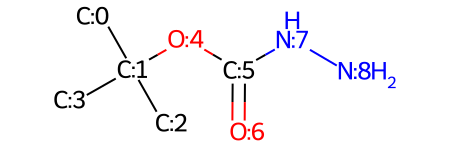

Candidate...


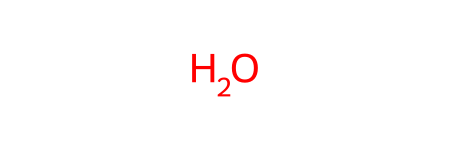

Verification... 3


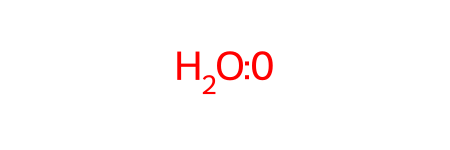

(0,)
Verification... 150
Verification... 148736
Candidate...


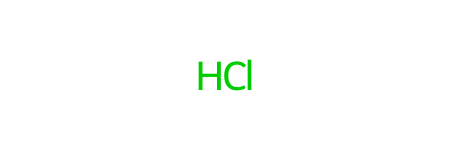

Verification... 1


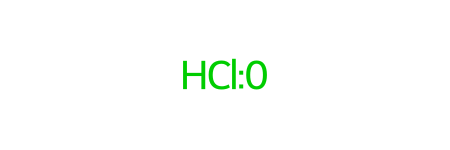

(2,)
Candidate...


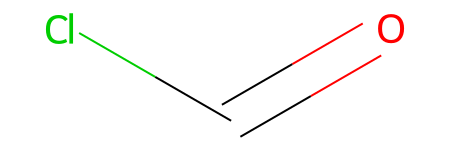

Verification... 2717


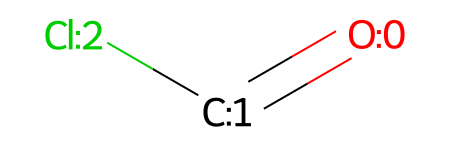

(0, 1, 2)
Verification... 8121


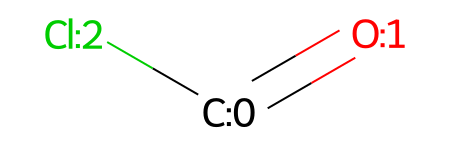

(1, 0, 2)
Candidate...


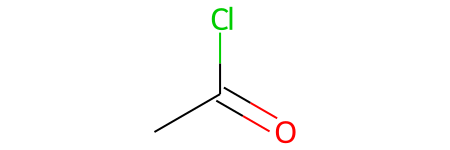

Verification... 11315
Verification... 195343
Verification... 106792


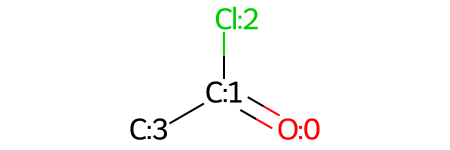

(0, 1, 2, 3)
Candidate...


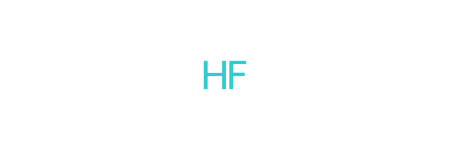

Verification... 87


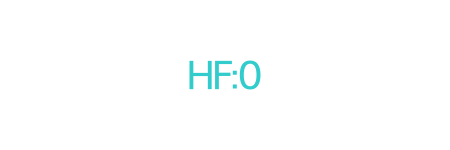

(8,)
Verification... 133400
Candidate...


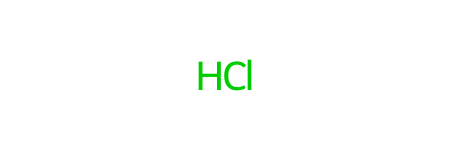

Verification... 1


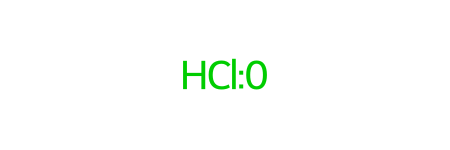

(2,)
[3, 1, 2717, 106792, 87, 1]


In [8]:
# For a new molecule, let's find all possible actions applicable
i = 2500
in_mol = Chem.MolFromSmiles(dataset.iloc[i]["reactants"])
out_mol = Chem.MolFromSmiles(dataset.iloc[i]["products"])
rsig = Chem.MolFromSmiles(dataset.iloc[i]["rsig"])
psig = Chem.MolFromSmiles(dataset.iloc[i]["psig"])

display(in_mol)
display(out_mol)
display(rsig)
display(psig)

def verify_action_applicability(mol, cluster_id):
    rsig = Chem.MolFromSmiles(dataset[dataset["rsig_clusters"]==cluster_id].iloc[0]["rsig"])
    rcen = dataset[dataset["rsig_clusters"]==cluster_id].iloc[0]["rcen"]
    
    # Check if the cluster rsig is in mol
    if not mol.HasSubstructMatch(rsig):
        return False
    
    # Check if the rcen matches
    match = mol.GetSubstructMatch(rsig)
    display(rsig)
    print(match)
    
    cand_rcen = match[rcen]
    cand_atom = mol.GetAtomWithIdx(cand_rcen)
    neighbors = list(map(lambda x: x.GetIdx(), cand_atom.GetNeighbors()))
    if not set(neighbors) - set(match):
        return False
    return True
    

# For each bridge, we find two disconnected components and search the smaller one in our index
G = nx.from_numpy_matrix(Chem.GetAdjacencyMatrix(in_mol))
applicable_actions = []
for x1, x2 in nx.bridges(G):
    mw = Chem.RWMol(in_mol)
    mw.RemoveBond(x1, x2)
    m1, m2 = Chem.MolToSmiles(mw).split(".")
    m = m1 if len(m1) < len(m2) else m2
    candidate = Chem.MolFromSmiles(m)
    print("Candidate...")
    display(candidate)
    cand_certi = get_mol_certificate(candidate)
    if cand_certi in certificate_to_cluster_id_dict:
        for cluster_id in certificate_to_cluster_id_dict[cand_certi]:
            print("Verification...", cluster_id)
            if verify_action_applicability(in_mol, cluster_id):
                applicable_actions.append(cluster_id)
                
print(applicable_actions)

In [200]:
def smiles_without_atom_index( smiles ):
    '''
    Convert smiles with numbers to smiles without numbers
    '''
    mol = Chem.MolFromSmiles(smiles)
    atoms = mol.GetNumAtoms()
    for idx in range( atoms ):
        mol.GetAtomWithIdx( idx ).ClearProp( 'molAtomMapNumber' )
    return Chem.MolToSmiles(mol)

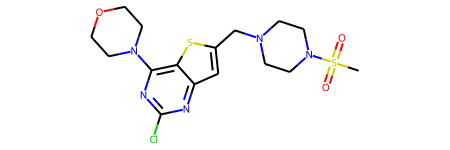

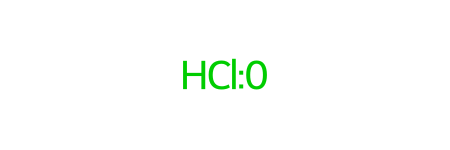

rcen 0


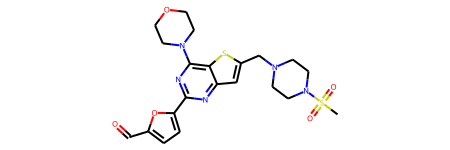

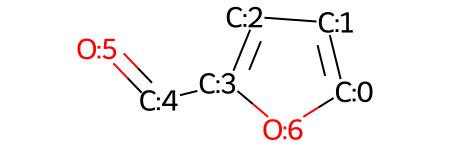

pcen 6


In [9]:
# Pick a random action from all the possible ones
temp_df = dataset[dataset["rsig_clusters"].isin(applicable_actions)]
random_action = temp_df.iloc[int(np.random.random()*temp_df.shape[0])]

display(Chem.MolFromSmiles(random_action["reactants"]))
display(Chem.MolFromSmiles(random_action["rsig"]))
print("rcen", random_action["rcen"])
display(Chem.MolFromSmiles(random_action["products"]))
display(Chem.MolFromSmiles(random_action["psig"]))
print("pcen", random_action["pcen"])

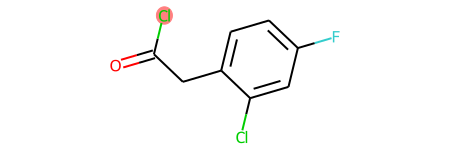

In [208]:
in_mol

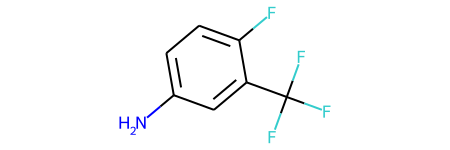

In [215]:
Chem.MolFromSmiles(smiles_without_atom_index(random_action["psig"]))

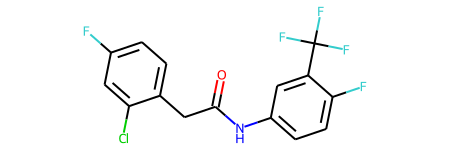

In [211]:
x = Chem.MolFromSmiles(Chem.MolToSmiles(in_mol).replace(
                                                    smiles_without_atom_index(random_action["rsig"]), 
                                                    smiles_without_atom_index(random_action["psig"]), 
                                                    1))
x

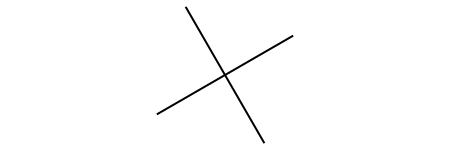

In [19]:
Chem.MolFromSmiles("CC(C)(C)C")

In [154]:
random_action["products"]

'Cc1cc(C)c(O)c(C(CCCCCC(=O)O)c2ccc(F)cc2)c1C'

In [42]:
l = []
for i in tqdm.tqdm(range(dataset.shape[0])):
    mol = Chem.MolFromSmiles(dataset.iloc[i]["reactants"])
    l.extend([atom.GetAtomicNum() for atom in mol.GetAtoms()])
    mol = Chem.MolFromSmiles(dataset.iloc[i]["products"])
    l.extend([atom.GetAtomicNum() for atom in mol.GetAtoms()])

100%|████████████████████████████████████████████████████████| 83055/83055 [00:31<00:00, 2678.01it/s]


In [45]:
pd.value_counts(l)

6     2838720
8      430859
7      361298
9       99547
17      54795
16      49776
35      22330
53       5336
14       4877
15       3671
5        2328
50        897
12        143
29         50
30         40
34         39
3          32
11         13
25         11
32         10
22         10
13         10
24          9
19          8
82          7
31          5
40          4
73          4
44          4
33          3
51          2
47          2
78          1
48          1
83          1
dtype: int64

In [13]:
mol = Chem.MolFromSmiles("CONC")

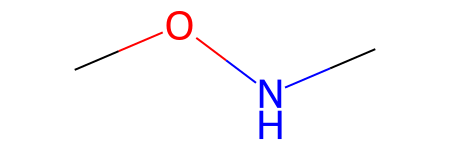

In [14]:
mol

In [152]:
Chem.GetAdjacencyMatrix(mol)

array([[0, 1, 0, 0],
       [1, 0, 1, 0],
       [0, 1, 0, 1],
       [0, 0, 1, 0]], dtype=int32)

In [15]:
mol = Chem.MolFromSmiles("CC(C)C")

In [16]:
adj_mat = Chem.GetAdjacencyMatrix(mol)

# Create a ring for each atom with size = atomic_num
atom_nums = np.array([atom.GetAtomicNum() for atom in list(mol.GetAtoms())])
# atom_nums[atom_nums == 6] = 1
mat_list = []
for atn in atom_nums:
    new_mat = np.zeros(shape=(atn, atn), dtype=np.int8)
    for i in range(atn):
        new_mat[i, (i+1)%atn] = 1
    mat_list.append(new_mat)

# conbine the rings into a new adj mat
new_adj_mat = np.zeros(shape=(sum(atom_nums), sum(atom_nums)), dtype=np.int8)
idx = 0
for i in range(len(atom_nums)):
    new_adj_mat[idx:idx+atom_nums[i], idx:idx+atom_nums[i]] = mat_list[i]
    idx += atom_nums[i]
    
# add original last connections
idx = 0
for i, a_i in enumerate(np.cumsum(atom_nums)):
    for j, a_j in enumerate(np.cumsum(atom_nums)):
        new_adj_mat[a_i-1, a_j-1] = adj_mat[i, j]
#         print(a_i-1, a_j-1, adj_mat[i, j])

In [17]:
for row in new_adj_mat:
    print(row)

[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]


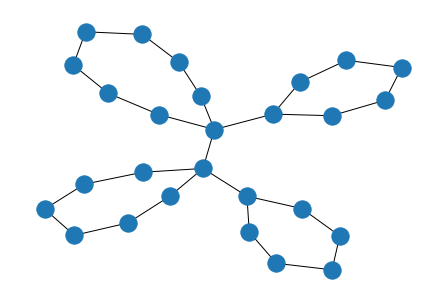

In [156]:
import networkx as nx
G = nx.from_numpy_matrix(new_adj_mat)

nx.draw_kamada_kawai(G)